# A Python script to evaluate longitudinal Automatic Tube Current Modulation (ATCM)
<font size="4">We have prepared parallel scripts to extract slice position and tube current from a CT scan and to generate synthetic radiographs from the CT image data. This is a tutorial for the Python version, prepared in the Jupyter software, which has a comfortable notebooky feel to it. Each block of code is explained in detail below, to the best of our abilities. The tutorial, in the form of a Jupyter notebook is also included in the repository. If you just want to run the code, or modify it to do something else for you, simply copy the ten blocks of input below and paste into a Python interpreter (e.g., Jupyter, Pycharm, Pydev, Visual Studio Code, Spyder, etc.). The practice of copying code from someone, i.e., the internet, to start solving problems may be considered a rule rather than an exception! </font>

## Section 1. Importing libraries
<font size="4">In Python, you need to import libraries with the functionality to solve a specific task. These libraries may first need to be installed on your computer before importing them, there is an abundance of inforrmation on how to install libraries on various operating systems online. Here we use <code>pydicom</code> for managing DICOM files, <code>matplotlib</code> for visualising our results, <code>numpy</code> for handling arrays, or matrices of data, and the libraries of <code>glob</code> and <code>pathlib</code> for assigning the library where our DICOM files are located.</font>

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path

## Section 2. Reading the DICOM data
<font size="4">When we have our libraries good to go, we start by assigning the directory where the files are located, in this example under /Phantom which is located in the user directory. Then we create three Python lists for storing our data, the tube current from each image slice (mA), each slice location (position), and finally a list to contain all the CT image data (pixelarray). Now we can call up the directory containing our DICOM data, loop through all the individual files, extract the data that we want and put the data in each designated list (mA, position, and pixelarray) using the <code>append</code> function. Note how list functions are used in Python, i.e., first we call a list and add a period (.) before calling Python to append all data gathered in the loop. In the loop we create a dataset with the <code>pydicom dcmread</code> command, and then directly call and append the dataset contents that we are interested in (XRayTubeCurrent, SliceLocation, and pixel_array).</font>

In [2]:
base_dir = Path("../Phantom/")

mA = []
position = []
pixelarray = []

for path in base_dir.glob("*.dcm"):
    dataset = pydicom.dcmread(path)
    mA.append(dataset.XRayTubeCurrent)
    position.append(dataset.SliceLocation)
    pixelarray.append(dataset.pixel_array)

## Section 3. Sorting the data and making a first plot of tube current and slice location
<font size="4">We have now arrived at a situation where we have all the data that we need to achieve the task we want to do. However, there is a problem - the data is disorganised due to the order of the DICOM files in our directory! This is very common, but there is also a very easy fix - use the DICOM tags for slice location to sort all the information (mA and location). For visualising the pixel arrays to create a synthetic radiograph, we will use the same sorting function in Section 4. First off, we will use <code>numpy</code> arrays for our data, which offers nice functionality for data manipulation. There are differences between Python lists and arrays, mainly that arrays can store data very compactly and offers possibilities for numerical operations, the latter for instance with <code>numpy</code>. When we have imported the <code>numpy</code> library as <code>np</code>, we call functions by <code>np.function</code>, e.g., here simply creating a new numpy array np_pos containing the slice location data from the original slice location array. Now that the data is in numpy arrays, we can use the <code>argsort</code> function to create an index to use on all our arrays for sorting them according to slice position (here sorted_pos and sorted_mA). Note here that we have three different names for the variable containing the slice position data (position, np_pos, and sorted_pos), each array offering something new (np_pos is the numpy array and sorted_pos is the numpy array ordered according to slice location).</font>

In [3]:
np_pos = np.array(position)
np_mA = np.array(mA)

pos_inds = np_pos.argsort() 
sorted_pos = np_pos[pos_inds]
sorted_mA = np_mA[pos_inds]

<font size="4">Now that the tube current and slice position data has been sorted, we are ready to plot these arrays (mA as a function of position). There are many libraries that can be used to create plots and visualisations in Python, here we have chosen to use the most common for starting with Python - <code>matplotlib</code>. You remember how we called Python functions in the previous sections, and matplotlib is no exception. We imported <code>matplotlib as plt</code>, so our initial call to create a plot is very simple - <code>plt.plot(sorted_pos, sorted_mA)</code>. However, this will create a pretty boring figure with only a line and no annotation. This is easily remedied with the following matplotlib functions, which are nicely named to tell us what they do (add x-  and y-axis labels, respectively, add plot title, save our plot as a PDF with a nice and high resolution, and finally showing the plot in our Jupyter notebook). The last line is important, if you don't use <code>plt.imshow()</code> you will need to open the PDF to check the plot (no inline graphics will be shown). Note that, just like in MATLAB, when we want to create informative visualisations in Python, we can get quite a few lines of code. It is not uncommon that, eventually, there will be more lines of code telling Python how to perform visualisation compared to the reading and manipulation of data! We will look more into visualisation in the following sections.</font>

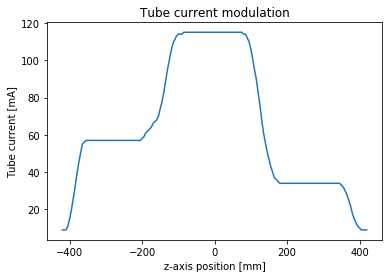

In [4]:
plt.plot(sorted_pos, sorted_mA)
plt.xlabel('z-axis position [mm]')
plt.ylabel('Tube current [mA]')
plt.title('Tube current modulation')
plt.savefig('TCM.pdf', dpi=600)
plt.show()

## Section 4. The pixel array
<font size="4">Now we have come to the matter of our pixel array, which is actually a list of arrays - our DICOM data files consists of 169 reconstructed CT images, so we will have a list of 169 two-dimensional arrays where each array represents the pixel values of one 512x512 image. By instinct working with such image data may appear more challenging than a simple array containing only tube currents or slice locations, but it’s really the same thing - and there is a lot to explore when working with images! To get some sense of this data we start by treating it the same way as the arrays containing tube current and slice location data, we create a numpy array for nifty manipulation functions and sort the individual CT images according to slice location.</font>

In [5]:
np_pixelarray = np.array(pixelarray)
sorted_pixelarray = np_pixelarray[pos_inds]

<font size="4">As mentioned, the CT images in their current state are still expressed as pixel values - not in HU, which is what we should be using when working with CT data. Fortunately, the DICOM files contains the information we need to translate from pixel value to HU. Remember that in our initial loop through the DICOM files we called this the dataset. From this dataset, values for slope and intercept are used to linearly rescale individual pixel values to HU (<code>dataset.RescaleSlope</code> and <code>dataset.RescaleIntercept</code>, respectively).</font>

<font size="4">There is a problem with our CT image pixel values. Outside of the reconstructed field of view we have anomalous values, less than -1024 HU after translation with slope and intercept. We will set all of these to -1000 HU. Note here that we do not create a new array, but simply overwrite the sorted pixel array adjusted with DICOM information on image slope and intercept (<code>slope_intercept_pixelarray[slope_intercept_pixelarray < -1024] = -1000</code>).</font>

In [6]:
slope_intercept_pixelarray = sorted_pixelarray*dataset.RescaleSlope + dataset.RescaleIntercept
slope_intercept_pixelarray[slope_intercept_pixelarray < -1024] = -1000

<font size="4">Now we are ready to create a synthetic radiograph. Note the abbreviation in the code (Scan Projection Radiograph, SPR, naming which is perhaps more appealing to some readers). This means that we will transform the 3D image data to 2D, i.e., sum our phantom image data from the anterior-posterior or lateral direction. We will do this with a loop, just like we did for initially reading all the CT image data from individual DICOM files in Section 2. Before looping through all the image data we need to do two things - 1) find out how many slices we have to define the loop (easily done by checking the length, <code>len</code>, of the pixel array), and 2) create an empty list to hold the synthetic radiograph data created by the loop (synthetic_SPR). In the loop we use the same function, <code>append</code>, as in Section 2, which adds data to our synthetic radiograph (synthetic_SPR) list for each iteration of the loop. Now we have a synthetic radiograph! Note that in the loop summation of pixel data you can chose either anterior-posterior (<code>axis=0</code>) or lateral (<code>axis=1</code>) view.</font>

In [7]:
n_slices = len(sorted_pixelarray)
synthetic_SPR = []
for i in range(n_slices):
    synthetic_SPR.append(slope_intercept_pixelarray[i].sum(axis=0))

<font size="4">However, our tube current vs. slice location data is longitudinal, as seen in the plot we made in Section 3. The current representation of our synthetic radiograph is each slice shown in order according to slice location (nice!) vertically stacked on top of the next (not nice when we want to visualise our phantom aligned with tube current modulation!). Fortunately, there is an easy fix for this, we can use a numpy function to transpose (<code>T</code>) our synthetic radiograph array. You can check the orientation of the original synthetic_SPR array using <code>plt.imshow(np.array(synthetic_SPR))</code>.</font>

In [8]:
np_synthetic_SPR = np.array(synthetic_SPR).T

<font size="4">Finally, we can get to work visualising our synthetic radiograph. We will do this with the <code>matplotlib</code> function <code>imshow</code>. However, before doing this we define the coordinate system in which to show the image, for the x-axis the slice locations and for the y-axis the number of pixels. Since this is a CT image, we know that this is likely to be 512 pixels to each side, but it’s better to check (some manufacturers offer higher resolution today, and photon counting CTs will definitely be working with larger matrices). Note that we define the nunmber of pixels as <code>len(np_synthetic_SPR) - 1</code>, which means that our first pixel has number 0 and the last will be 511. This was done to reflect that in Python indexing starts from 0, while MATLAB will start from 1. As seen in the example, the <code>imshow</code> command is easy to use, you define the image to visualise (np_synthetic_SPR), assign a colour map (<code>cm.gray</code>), and the extent of our image. The rest of the matplotlib commands are the same as we used to create, save, and show the tube current modulation as a function of slice position.</font>

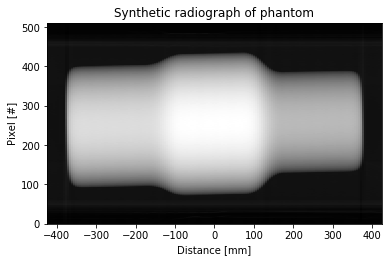

In [9]:
xminpos = sorted_pos[0] - 5
xmaxpos = sorted_pos[168] + 5
n_pixels = len(np_synthetic_SPR) - 1
plt.imshow(
    np_synthetic_SPR, 
    cmap=plt.cm.gray, 
    extent=[xminpos, xmaxpos, 0, n_pixels]
    )

plt.title("Synthetic radiograph of phantom")
plt.xlabel('Distance [mm]')
plt.ylabel('Pixel [#]')
plt.savefig('Syntetic radiograph.pdf', dpi=600)
plt.show()

## Section 5. Showing the tube current modulation together with our synthetic radiograph
<font size="4">From the previous sections you now know how to read DICOM data in Python, how to sort the data, extract individual DICOM tags, visualising DICOM tag data and images, respectively. However, since we have come this far there is one final thing that may be nice to do - showing the tube current modulation together with our synthetic radiograph to compare how the CT manages to modulate the mA according to the physical size of the ATCM phantom. And this is very straightforward. We have already used most of the commands necessary to achieve the final figure. First off, since we now have two sets of figure data (the tube current as a function of slice location, and the synthetic radiograph) we need to let matplotlib know this by the <code>fig, ax = plt.subplots()</code> command. Note that we now have two arguments for the matplotlib command (<code>fig, ax</code>), and we will use <code>ax</code> instead of <code>plt</code> (as earlier) to call matplotlib functions and create our final figure. Furthermore, we want the tube current to dictate our y-axis, not the number of pixels as when we only visualised the synthetic radiograph (assign the maximum tube current used and add 5 for aesthetic purposes). Furthermore, there is a nice function in matplotlib imshow to help us align the two data sets - <code>aspect = ‘auto’</code> helps us to automatically set the aspect ratio of height to width of the resulting figure. Finally, we chose to show the tube current as a function of slice location as individual points, not a solid line as in Section 3.</font>

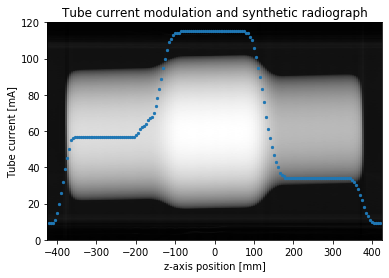

In [10]:
fig, ax = plt.subplots()

ymaxpos = sorted_mA.max() + 5
ax.imshow(
    np_synthetic_SPR, 
    cmap=plt.cm.gray, 
    extent=[xminpos, xmaxpos, 0, ymaxpos], 
    aspect='auto'
    ) 

ax.scatter(sorted_pos, sorted_mA, marker='o', s=5)
plt.xlabel('z-axis position [mm]')
plt.ylabel('Tube current [mA]')
plt.title('Tube current modulation and synthetic radiograph')
plt.savefig('TCM and radiograph.pdf', dpi=600)
plt.show()

<font size="4">There are many ways to achieve the above in Python. You could use other libraries, or commands within the same libraries that we chose. Perhaps there are easier and more intuitive solutions than what we achieved. What do you think? Let us know!</font>

<font size="4">Jonas Andersson (jonas.s.andersson@umu.se)</font>